## Running the notebook
All code and program dependencies such as pythia, rivet, hepmc, Ax are preinstalled on the docker image `alialkadhim/pythia_sbi_tune:latest`. Here is how to install the image and run this notebook:

```
git clone https://github.com/AliAlkadhim/Pythia8_SBI_Tune.git
```
Then,
```
cd Pythia8_SBI_Tune/code/BayesOpt
bash docker_run.sh
```

Then, inside the docker container, do

```
jupyter-lab --ip 0.0.0.0 --port 8889 --allow-root &
```

Now copy and paste the link displayed at the bottom of the terminal to your browser.

----

This notebook performs Bayesian Optimizaion using GPytorch of the Lund string model parameters that appear in the fragmentation function

$$
f_{\text{Lund}}(z) \propto \frac{1}{z^{1+r_Q b m_Q^2}}(1-z)^{a'_i} \exp \left(-\frac{b m_{\perp}^2}{z}\right),
$$

As well as other important flavor and shower parameters. For detailed description of these parameters, see my overleaf writeup.

We use the data from `ALEPH_1996_S3486095` from the paper ["Studies of quantum chromodynamics with the ALEPH detector"](https://www.sciencedirect.com/science/article/pii/S0370157397000458)


## Key Observations
The default values of these parameters in pythia is due to the [Monash Tune](https://arxiv.org/pdf/1404.5630.pdf). Other papers have corroborated the results of that tune and attained similar values for some of the parameters. Therefore, when performing the Bayesian Optimization, we want to take that into account by forcing the algorithm to sample the Monash tune point. Observe how with few number of iterations, while forcing the sobol quasirandom sampling to explore the Monash tune, we will most likely end up with the Monash tune as the best-fit point. However, when we increase the number of iterations, we arrive at a tune that is slightly different than the Monash tune.

In [1]:
import numpy as np
import torch
import gpytorch
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel
from gpytorch.distributions import MultivariateNormal
import matplotlib.pyplot as plt

#`source /cvmfs/sft.cern.ch/lcg/views/LCG_102/x86_64-centos7-gcc11-opt/setup.sh`
from glob import glob
from tqdm import tqdm
import yoda2numpy_BayesOpt
from yoda2numpy_BayesOpt import Yoda2Numpy

import pythia_SBI_utils
from pythia_SBI_utils import *

FONTSIZE = 14
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : FONTSIZE}
mp.rc('font', **font)

# set usetex = False if LaTex is not 
# available on your system or if the 
# rendering is too slow
mp.rc('text', usetex=True)


In [177]:
MAX_PROB = 10.0
PARAM_DICT = {
        'StringZ:aLund' : [0, 2.0],
        'StringZ:bLund': [0, 2.0],
        'StringZ:rFactC':[0.0, 2.0],
        'StringZ:rFactB': [0., 2.0],
        'StringZ:aExtraSQuark':[0.,2.],
        'StringZ:aExtraDiquark':[0.,2.],
        'StringPT:sigma':[0.,1.],
        'StringPT:enhancedFraction':[0.,1.],
        'StringPT:enhancedWidth':[1.0,MAX_PROB],
        'StringFlav:ProbStoUD':[0,MAX_PROB],
        'StringFlav:probQQtoQ':[0,MAX_PROB],
        'StringFlav:probSQtoQQ':[0,MAX_PROB],
        'StringFlav:ProbQQ1toQQ0':[0,MAX_PROB],
        'TimeShower:alphaSvalue':[0.06,0.25],
        'TimeShower:pTmin':[0.1,2.0]


}

MONASH_DICT = {
    "aLund" : 0.68, 
    "bLund" : 0.98,
    "rFactC": 1.32,
    "rFactB":0.855,
    "aExtraSQuark": 0.0,
    "aExtraDiquark":0.97,
    "sigma":0.335,
    "enhancedFraction":0.01,
    "enhancedWidth":2.0,
    "ProbStoUD":0.217,
    "probQQtoQ":0.081,
    "probSQtoQQ":0.915,
    "ProbQQ1toQQ0": 0.0275,
    "alphaSvalue": 0.1365,
    "pTmin": 0.5
}

REDUCED_MONASH_DICT = {
    "aLund" : 0.68, 
    "bLund" : 0.98,
    "aExtraSQuark": 0.0,
    "sigma":0.335,
    "enhancedFraction":0.01,
    "ProbStoUD":0.217,
    "probQQtoQ":0.081,
    "probSQtoQQ":0.915,
    "alphaSvalue": 0.1365,
    "pTmin": 0.5
}


def get_param_prefix(param):
    for key,val in PARAM_DICT.items():
        prefix, postfix = key.split(':')
        if postfix == str(param):
            return prefix

param_names = list(PARAM_DICT.keys())
print(len(PARAM_DICT))

15


In [3]:
class Sample_param:
    def __init__(self, param, size):
        self.param = param
        self.size = size
    def uniform(self):
        param_prefix = get_param_prefix(self.param)
        pre_postfix = param_prefix + ':' + self.param
        return torch.tensor(np.random.uniform(
                low=PARAM_DICT[pre_postfix][0],
                high=PARAM_DICT[pre_postfix][1],
                size=self.size))

    def linspace(self):
        param_prefix = get_param_prefix(self.param)
        pre_postfix = param_prefix + ':' + self.param
        return torch.linspace(start=PARAM_DICT[pre_postfix][0],
                end=PARAM_DICT[pre_postfix][1],
                steps=self.size)


## Considererations for Data and Effective counts
Notice (unfortunately) that the total effective counts for every histogram is different! This is a huge complication because, in principle, we would need to generate different numbers of events for every histogram. But, as is true of much of what we do in science, we should make some simplifying assumptions to reduce to complexity of the problem. 

**Assumptions**

  1. Since we are not given correlation matrices for the measured cross sections, we assume that the bin-by-bin cross section measurements are conditionally independent: given fixed values of the tune parameters the measured cross sections are statistically independent.
  2. The counts per bin are Poisson-distributed and the cross sections are just scaled values of the counts.  We can, therefore, compute the effective count in each bin using the following *ansatz*
\begin{align}
    n_i & = k_i \sigma_i,\\
    \sqrt{n_i} & = k_i \delta \sigma_i \quad \text{and, therefore, }\\
    n_i & = \left( \frac{\sigma_i}{\delta\sigma_i} \right)^2 ,
\end{align}
where $\sigma_i \pm \delta\sigma_i$ is the measured cross section in bin $i$ and $k_i$, the *effective integrated luminosity*, is the product $\epsilon_i {\cal L}$ of the efficiency times acceptance, $\epsilon_i$, and  the integrated luminosity ${\cal L}$. The total effective count for a histogram is then just $n = \sum_{i} n_i$.

Therefore, for each tune parameter point, a sufficiently large sample of simulated events will result in histograms that serve both as the predictions as well as the basis for simulating events counts in all the simulated "observed" histograms. Given our assumptions, we can write down an approximation of the statistical model, $p(X | \theta)$, where $X$ are *potentially observable* counts and $\theta$ are the tune parameters. With the assumptions above, the statistical model for the $\texttt{ALEPH}$ data can be approximated as a product of either gamma or Gaussian densities depending on the size of the effective bin counts. We see that about 300,000 events need to be simulated per point in order to match the statistical precision of the data.

## .yoda format
The .yoda histograms for the data look like:

```
# xval	 xerr-	 xerr+	 yval	 yerr-	 yerr+
```
`xval` is the bin center, while `yval` is the height of the bin center. `xerr-=xerr+` is the positive and uncertainties in the bin center location, and `yerr-=yerr+` is the uncertainty in the height.

The data recorded is the cross section. so let's call that cross section in bin i $\hat{\sigma}_i^{Data} =yval$ and the uncertainty in bin i $\Delta^{Data}_i = yerr-$ . 


while the simulation histograms look like:
```
xlow	 xhigh	 sumw	 sumw2	 sumwx	 sumwx2	 numEntries
```

`xlow` is the left edge and `xhigh` is the right edge for a bin $i$. `sumw` is the sum of weights per bin $i$ $sumw^{bin, i} \sum_{k=1}^{N_{counts \ in \ bin \ i}} w_k^{bin \ i}$ and `sumw2` is sum of weights squared $sumw2^{bin \ i}=\sum_{k=1}^{N_{counts \ in \ bin \ i}} (w_k^{bin \ i})^2$ . To convert to differential cross section we divide by the bin widths, i.e. we calculate $\Delta x = xhigh-xlow$ and divide $\hat{\sigma}_i^{MC} = sumw/\Delta x$ and $sumw2/\Delta x ^2$ and $sumwx/\Delta x$ and $sumwx2/Delta x^2$ . Then the MC error for the cross section per bin is $\Delta_i^{MC} =\sqrt{sumw2/\Delta x ^2}$ 

We can write the effective count can be as
$$\frac{\sqrt{\sum_i w_i^2}}{\sum_i w_i}=\frac{1}{\sqrt{N_{e f f}}}$$
So 
$$N_{eff,\ i} = \left( \frac{\sum_i w_i }{\sqrt{\sum_i w_i^2 } } \right)^2 = \left( \frac{\sum_i w_i}{\Delta_{i, MC}} \right)^2$$
Therefore the scale factor per bin is

$$K_i = \frac{\sum_i w_i}{\sum_i w_i^2 }= \frac{\sum_i w_i}{\Delta_{i,MC}^2}$$

------

We use the following test statistic
$$
    \lambda(X; \theta) = \sqrt{\frac{1}{N}\sum_\text{histograms} \sum_i \left( \frac{D_i - T_i(\theta)}{\delta_i} \right)^2},
$$
where $N$ is the total number of bins summed over histograms and $\delta_i^2$ is the sum of the variances associated with the data $D_i$ and the theoretical prediction $T_i$ with the latter obtained via Monte Carlo simulation.

In [72]:
def make_pythia_card(aLund, 
                     bLund,
                    rFactC,
                    rFactB,
                    aExtraSQuark,
                    aExtraDiquark,
                    sigma,
                    enhancedFraction,
                    enhancedWidth,
                    ProbStoUD,
                    probQQtoQ,
                    probSQtoQQ,
                    ProbQQ1toQQ0,
                    alphaSvalue,
                    pTmin):
    
    
    cards_dir = os.path.join(os.getcwd(), "BO_Cards")
    filename = f"ALEPH_1996_S3486095_BO_card.cmnd"
    file_path = os.path.join(cards_dir, filename)
    with open(file_path,'w') as f:
        first_block="""Main:numberOfEvents = 2500          ! number of events to generate
Next:numberShowEvent = 0           ! suppress full listing of first events
# random seed
Random:setSeed = on
Random:seed= 0
! 2) Beam parameter settings.
Beams:idA = 11                ! first beam,  e- = 11
Beams:idB = -11                ! second beam, e+ = -11
Beams:eCM = 91.2               ! CM energy of collision
# Pythia 8 settings for LEP
# Hadronic decays including b quarks, with ISR photons switched off
WeakSingleBoson:ffbar2gmZ = on
23:onMode = off
23:onIfAny = 1 2 3 4 5
PDF:lepton = off
SpaceShower:QEDshowerByL = off\n\n"""
        f.write(first_block)
        # f.write(f"Random:seed={indx+1}")
        f.write(f"StringZ:aLund = {aLund}\n\n")
        f.write(f"StringZ:bLund = {bLund}\n\n")
        f.write(f"StringZ:rFactC = {rFactC}\n\n")
        f.write(f"StringZ:rFactB = {rFactB}\n\n")
        f.write(f"StringZ:aExtraSQuark = {aExtraSQuark}\n\n")
        f.write(f"StringZ:aExtraDiquark = {aExtraDiquark}\n\n")
        f.write(f"StringPT:sigma = {sigma}\n\n")
        f.write(f"StringPT:enhancedFraction = {enhancedFraction}\n\n")
        f.write(f"StringPT:enhancedWidth = {enhancedWidth}\n\n")
        f.write(f"StringFlav:ProbStoUD = {ProbStoUD}\n\n")
        f.write(f"StringFlav:probQQtoQ = {probQQtoQ}\n\n")
        f.write(f"StringFlav:probSQtoQQ = {probSQtoQQ}\n\n")
        f.write(f"StringFlav:ProbQQ1toQQ0 = {ProbQQ1toQQ0}\n\n")
        f.write(f"TimeShower:alphaSvalue = {alphaSvalue}\n\n")
        f.write(f"TimeShower:pTmin = {pTmin}\n\n")
        


def get_pbounds(PARAM_DICT):
    pbounds = {}
    for key, value in PARAM_DICT.items():
        p_name = key.split(':')[1]
        p_bound = tuple(value)
        pbounds[p_name] = p_bound
    return pbounds

In [5]:
def reduce_filtered_keys(filtered_data_keys, filtered_mc_keys):
    # Initialize empty list for the reduced keys
    reduced_data_keys = []
    reduced_mc_keys = []
    # List of histogram keys that need to be removed
    hists_to_remove = ['d35-x01-y01', 'd36-x01-y01', 'd39-x01-y01', 'd40-x01-y01']
    
    # Iterate over each data key
    for data_key in filtered_data_keys:
        # Add the key to reduced_data_keys only if it does not match any hist_to_remove
        if not any(hist_to_remove in str(data_key) for hist_to_remove in hists_to_remove):
            reduced_data_keys.append(data_key)

    for mc_key in filtered_mc_keys:
        # Add the key to reduced_data_keys only if it does not match any hist_to_remove
        if not any(hist_to_remove in str(mc_key) for hist_to_remove in hists_to_remove):
            reduced_mc_keys.append(mc_key)
            
        
    return reduced_data_keys, reduced_mc_keys

        

In [6]:
importlib.reload(yoda2numpy_BayesOpt)
from yoda2numpy_BayesOpt import Yoda2Numpy
importlib.reload(pythia_SBI_utils)
from pythia_SBI_utils import *

def true_objective_func(aLund, 
                     bLund,
                    rFactC,
                    rFactB,
                    aExtraSQuark,
                    aExtraDiquark,
                    sigma,
                    enhancedFraction,
                    enhancedWidth,
                    ProbStoUD,
                    probQQtoQ,
                    probSQtoQQ,
                    ProbQQ1toQQ0,
                    alphaSvalue,
                    pTmin):
    
    # step 1: write .cmnd file 
    make_pythia_card(aLund, 
                     bLund,
                    rFactC,
                    rFactB,
                    aExtraSQuark,
                    aExtraDiquark,
                    sigma,
                    enhancedFraction,
                    enhancedWidth,
                    ProbStoUD,
                    probQQtoQ,
                    probSQtoQQ,
                    ProbQQ1toQQ0,
                    alphaSvalue,
                    pTmin)
    #step 2 run main42 and rivet
    os.system("""./main42 BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo
    rivet -o ALEPH_1996_S3486095_hist_0.yoda -a ALEPH_1996_S3486095 /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo

    rm /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo
    mv ALEPH_1996_S3486095_hist_0.yoda ALEPH_YODAS_BayesOpt/""")
    

    #step 3: get generated yoda file histograms in the form of dataframes
    dfdata, dfsims, generated_indices = get_data()
    print('DATA DATAFRAME')
    print(dfdata['/REF/ALEPH_1996_S3486095/d01-x01-y01'].head())
    print('FIRST SIM DATAFRAME')
    print(dfsims[generated_indices[0]]['/ALEPH_1996_S3486095/d01-x01-y01'].head())

    #step 4: fileter histograms based on our criteria
    data_keys, mc_keys = get_hist_names(dfdata)

    filtered_data_keys, filtered_mc_keys = filter_keys(dfdata, dfsims, data_keys, mc_keys)

    #step 4.5: take out bad histograms
    reduced_data_keys, reduced_mc_keys = reduce_filtered_keys(filtered_data_keys, filtered_mc_keys)

    
    #step 5: get test statistic at each point
    X0 = {}
    for ii, gen_ind in enumerate(generated_indices):
        # X0.append(test_statistic(filtered_data_keys,filtered_mc_keys, dfdata, dfsims[gen_ind], which = 0))
        # try:
        #     X0.append(test_statistic(filtered_data_keys,filtered_mc_keys, dfdata, dfsims[ii], which = 0))
        try:
            X0[gen_ind] = test_statistic(reduced_data_keys,
                                         reduced_mc_keys, 
                                         dfdata, 
                                         dfsims[gen_ind], 
                                         which = 0)
        except Exception:
            print('test statistic error in file index: ', gen_ind)
            
            
    objective_func = X0[0]
        
    os.system("rm ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda")
        
    print(f"objective function = {objective_func}")
    return objective_func

## Gaussian Process Regression

A data set $\mathcal{D}= \left\{ \mathbf{x}, \mathbf{y} \right\} = \left \{ (x_i, y_i), x_i \in \mathbb{R}^d, y_i \in \mathbb{R} \right \}_{i = 1}^N$ is given.  

The assumption is that the actual observations are a noise-corrupted value of the true model:
$$
y = f(x) + \varepsilon, \tag{1}
$$
where $f(x)$ is a Gaussian Processes and $\varepsilon \sim \mathcal{N}(0, \sigma_n^2)$ is a Gaussian noise. FOr example, the model could be $f(\mathbf{x}) = \mathbf{w}^T \mathbf{x}$.  

In general, the posterior predictive distribution marginalizes over the model parameters $w$:

$$ p(y \mid x, \mathcal{D}) = \int p(y, w \mid x, \mathcal{D}) d w = \int p(y \mid x, w) p(w \mid \mathcal{D}) dw \tag{2}$$

Using Eq. (1), one can write the likelihood, which is Gaussian

$$p(y \mid w) = p(y \mid x, w) = \mathcal{N}(y; f(x), \sigma^2)$$

However, the integral in Eq. (1) is intractable in closed form. The trick is realizing that the first term in Eq. (1) is a Gaussian. Furthermore, $p(w \mid \mathcal{D}) = \frac{p(\mathcal{D} \mid w) p(w)}{Z}$ is a product of Gaussians normalized by a Gaussian, so it is also a Gaussian, therefore, $p(y \mid x, \mathcal{D}) $ is a Gaussian.


$p(\mathbf{y}\mid\mathbf{x})$ is thus fully specified by the Kernel, and it starts out being the Gaussian process prior
$$ p(y_1, ... y_n \mid x_1, .., x_n)  = \mathcal{N}(y;0, \Sigma) \tag{3}$$ 
Where, $\Sigma$ can be decomposed as

$$ \Sigma =  \begin{pmatrix}
k & k_* \\
k_*^T & k_{**}
\end{pmatrix} $$

Another way to write Eq. (3) is
$$ \left[\begin{array}{c}
f\left(x^*\right) \\
f\left(x_1\right) \\
\vdots \\
f\left(x_n\right)
\end{array}\right] \sim N\left(\left[\begin{array}{c}
0 \\
0 \\
\vdots \\
0
\end{array}\right],\left[\begin{array}{cc}
k\left(x^*, x^*\right) & k\left(x^*, \mathbf{x}\right)^T \\
k\left(x^*, \mathbf{x}\right) & K_{\mathbf{x x}}
\end{array}\right]\right)$$


where the the kernel components $k$'s are functions of $x_1,...,x_n$ and $x_*$
$$
\mathbf{k} = \left ( k(x_*, x_1), \ldots, k(x_*, x_N) \right )^T
$$

The most commonly used kernel is the RBF kernel  $\Sigma_{x,y} = k(x, y) = \exp\left ( -\dfrac{\|x - y\|^2}{2l^2}\right )$,
where $l$ is a `lengthscale`.  There is usually a multiplicative constant in front which controls the amplitude, and can be accessed with `ScaleKernel(RBFKernel())`

Now, given a new data point $x^*$, $y^*$ can be predicted with
$$
y_* | \mathcal{D}, x_* \sim \mathcal{N}(m(x_*), \sigma(x_*)), \tag{4}
$$
with predictive mean and variance given by
$$
m(x_*) = \mathbf{k}^T \mathbf{K}_y^{-1} \mathbf{y} = \sum_{i = 1}^N \alpha_i k(x_*, x_i),
$$
$$
\sigma^2(x_*) = k(x_*, x_*) - \mathbf{k}^T\mathbf{K}_y^{-1}\mathbf{k},
$$

$$
\mathbf{K}_y = \|k(x_i, x_j)\|_{i, j = 1}^N + \sigma_n^2 \mathbf{I}
$$



In [174]:
class GPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean()
        self.covar_module = ScaleKernel(RBFKernel(ard_num_dims=train_x.size(-1)))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)

    def predict(self, train_x):
            self.eval()
            with torch.no_grad():
                pred = self(train_x)
                return self.likelihood(pred)
                

A rule of thumb is to choose the training set size to be 10-20 times the number of parameters. This gives us 150-300 examples.

In [175]:
# SUBSAMPLE = 12
train_df = pd.read_csv('LHS_DF_with_chi2.csv')[:SUBSAMPLE]
train_df = pd.read_csv('ALL_PRAMS_DF_with_chi2.csv')
train_df.head()

,Unnamed: 0.1,Unnamed: 0,StringZ:aLund,StringZ:bLund,StringZ:rFactC,StringZ:rFactB,StringZ:aExtraSQuark,StringZ:aExtraDiquark,StringPT:sigma,StringPT:enhancedFraction,StringPT:enhancedWidth,StringFlav:ProbStoUD,StringFlav:probQQtoQ,StringFlav:probSQtoQQ,StringFlav:ProbQQ1toQQ0,TimeShower:alphaSvalue,TimeShower:pTmin,chi2
0,8,8,0.556011,0.868502,0.016574,1.885064,1.141008,1.149257,0.772040,0.389686,5.495607,1.779125,8.889039,1.710556,5.269230,0.082390,0.546031,41.437531
1,24,24,1.347008,1.575685,0.977640,1.167969,0.773779,0.016292,0.638895,0.179280,1.877969,6.952362,7.905230,8.762750,0.904564,0.096478,1.980862,37.346173
2,28,28,1.543559,1.022799,0.904395,1.504546,1.186068,1.893300,0.720731,0.968208,6.373499,5.519244,9.843051,3.767338,5.754264,0.246242,1.052530,13.652770
3,30,30,0.553772,1.436878,0.775175,1.947637,1.904903,1.887840,0.028010,0.075157,4.746784,0.699915,6.476105,4.104564,8.169165,0.097954,0.405812,37.277339
4,34,34,1.068297,1.701151,1.041949,0.120821,0.301263,1.436722,0.668147,0.748136,2.032139,4.489065,0.487187,7.734206,7.340845,0.098171,1.263785,37.802948


In [176]:
train_df.describe()

,Unnamed: 0.1,Unnamed: 0,StringZ:aLund,StringZ:bLund,StringZ:rFactC,StringZ:rFactB,StringZ:aExtraSQuark,StringZ:aExtraDiquark,StringPT:sigma,StringPT:enhancedFraction,StringPT:enhancedWidth,StringFlav:ProbStoUD,StringFlav:probQQtoQ,StringFlav:probSQtoQQ,StringFlav:ProbQQ1toQQ0,TimeShower:alphaSvalue,TimeShower:pTmin,chi2
count,5920.000000,5920.000000,5920.000000,5920.000000,5920.000000,5920.000000,5920.000000,5920.000000,5920.000000,5920.000000,5920.000000,5920.000000,5920.000000,5920.000000,5920.000000,5920.000000,5920.000000,5920.000000
mean,8911.595608,8911.595608,0.995204,1.099467,1.004883,0.990978,0.986737,0.995488,0.506634,0.513010,5.610833,5.093172,4.988632,5.025424,5.024797,0.152454,1.066297,37.855307
std,5908.718131,5908.718131,0.575077,0.518232,0.575859,0.579739,0.576744,0.579713,0.283270,0.288919,2.584443,2.872869,2.901697,2.904940,2.906784,0.055060,0.553461,13.105656
min,8.000000,8.000000,0.000188,0.200111,0.001055,0.000150,0.000022,0.000068,0.000386,0.000170,1.002808,0.001219,0.003608,0.000023,0.000261,0.060029,0.100403,5.115271
25%,4722.750000,4722.750000,0.497319,0.655044,0.496687,0.490623,0.484520,0.497627,0.266299,0.263357,3.436969,2.637359,2.450706,2.460704,2.541225,0.104102,0.581106,34.141488
50%,8254.500000,8254.500000,0.987451,1.090064,1.010569,0.980050,0.984697,0.994786,0.509693,0.523057,5.648923,5.136345,5.010202,5.036097,5.039501,0.150568,1.073235,39.112336
75%,11227.250000,11227.250000,1.495222,1.544473,1.511873,1.493187,1.471373,1.491940,0.748118,0.762366,7.855471,7.581837,7.474690,7.590791,7.574581,0.199468,1.551291,45.158612
max,24998.000000,24998.000000,1.999933,1.997968,1.999832,1.999705,1.999817,1.999827,0.999893,0.999873,9.999584,9.995127,9.999126,9.995000,9.999296,0.249987,1.998885,82.502571


In [182]:
train_x = train_df[param_names].to_numpy()
train_y = train_df['chi2'].to_numpy()

In [183]:
train_x.shape

(5920, 15)

In [184]:
train_y.shape

(5920,)

In [153]:
class Sample_param:
    def __init__(self, param, size):
        self.param = param
        self.size = size
    def uniform(self):
        param_prefix = get_param_prefix(self.param)
        pre_postfix = param_prefix + ':' + self.param
        return torch.tensor(np.random.uniform(
                low=PARAM_DICT[pre_postfix][0],
                high=PARAM_DICT[pre_postfix][1],
                size=self.size))

    def linspace(self):
        param_prefix = get_param_prefix(self.param)
        pre_postfix = param_prefix + ':' + self.param
        return torch.linspace(start=PARAM_DICT[pre_postfix][0],
                end=PARAM_DICT[pre_postfix][1],
                steps=self.size)

### Make new dataset here in jupyter

In [154]:
def make_train_dataset(PARAM_DICT, points):
    param_names = list(PARAM_DICT.keys())
    column_names = param_names + ['chi2']
    
    rows = []
    for _ in range(points):
        row = []
        for param_name, range_ in PARAM_DICT.items():
            param_postfix = param_name.split(':')[1]
            uniform_size_1 = Sample_param(param=param_postfix, size=1).uniform().item()
            row.append(uniform_size_1)
        
        chi2 = true_objective_func(*row)
        row.append(chi2)
        rows.append(row)
    
    df = pd.DataFrame(rows, columns=column_names)
    return df

In [107]:
train_df_new = make_train_dataset(PARAM_DICT, 75)


 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Traceback (most recent call last):
  File "/usr/local/bin/rivet", line 213, in <module>
    all_analyses = rivet.AnalysisLoader.analysisNames() #< excludes aliases
KeyboardInterrupt


[0]
looping over 1 sim yoda files...



  0%|                                                     | 0/1 [00:00<?, ?it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda


FileNotFoundError: ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

In [499]:
train_df_new.describe()

,StringZ:aLund,StringZ:bLund,StringZ:rFactC,StringZ:rFactB,StringZ:aExtraSQuark,StringZ:aExtraDiquark,StringPT:sigma,StringPT:enhancedFraction,StringPT:enhancedWidth,StringFlav:ProbStoUD,StringFlav:probQQtoQ,StringFlav:probSQtoQQ,StringFlav:ProbQQ1toQQ0,TimeShower:alphaSvalue,TimeShower:pTmin,chi2
count,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000
mean,1.024165,1.054585,1.084380,0.991521,0.911402,1.187171,0.490522,0.415595,2.509142,1.991589,2.035131,1.934464,1.983899,0.162765,0.980156,39.612894
std,0.574277,0.583546,0.600075,0.565680,0.518722,0.544235,0.277581,0.267377,0.893851,1.122669,1.258252,1.118541,1.089561,0.056914,0.520526,10.400232
min,0.023940,0.011581,0.009009,0.050850,0.072157,0.104720,0.003080,0.014562,1.047797,0.019426,0.077434,0.072592,0.063163,0.062414,0.112414,12.094384
25%,0.513596,0.582569,0.496514,0.488645,0.478093,0.775668,0.244520,0.196665,1.646296,1.045230,0.859674,1.091707,0.982966,0.104994,0.502800,33.589837
50%,1.051557,1.028745,1.090294,0.934820,0.937415,1.339954,0.486186,0.404398,2.444228,1.939143,2.189786,1.724426,2.084855,0.178182,0.959600,38.086453
75%,1.524026,1.650432,1.588286,1.475464,1.284238,1.604564,0.755765,0.575821,3.420676,3.015661,3.187998,2.881929,2.903214,0.209231,1.298491,44.197712
max,1.994026,1.918090,1.996329,1.998909,1.983874,1.999732,0.987084,0.993511,3.988504,3.985817,3.866482,3.942006,3.824085,0.247729,1.967896,72.540827


In [155]:
train_x = train_df_new[param_names].to_numpy()
train_y = train_df_new['chi2'].to_numpy()
train_x.shape

NameError: name 'train_df_new' is not defined

## Define model and likelihood

In [185]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
train_x = torch.tensor(train_x)
train_y = torch.tensor(train_y)

model = GPModel(train_x = train_x, train_y=train_y, likelihood=likelihood).double()

In [186]:
model.train_targets

tensor([41.4375, 37.3462, 13.6528,  ..., 45.2674, 28.1799, 41.2030],
       dtype=torch.float64)

In [187]:
model.train_inputs[0].shape

torch.Size([5920, 15])

In [188]:
def make_x_candidates(PARAM_DICT, size):
    full_matrix = np.empty((size, len(PARAM_DICT)))
    
    for row in range(size):
        result=[]
        for key, val in PARAM_DICT.items():
            param_name, range_ = key, val
            param_postfix = param_name.split(':')[1]
            uniform_size_1 = Sample_param(param=param_postfix, size=1).uniform().item()
            result.append(uniform_size_1)
        full_matrix[row,:] = result
        
    result = full_matrix
    
    # print(result)
    return torch.tensor(result)

In [189]:
x_candidates = make_x_candidates(PARAM_DICT,2)
print(x_candidates[0])

tensor([0.0750, 1.4329, 1.0244, 1.8590, 1.1847, 0.2997, 0.8917, 0.5613, 5.5715,
        7.0944, 8.5626, 9.8066, 8.8649, 0.2319, 0.5801], dtype=torch.float64)


In [113]:
x_candidates_aLund =x_candidates[:,0]
print(x_candidates_aLund)

tensor([1.1111, 1.3506], dtype=torch.float64)


In [114]:
# make sure you can call model on x_candidates
model.predict(x_candidates)

MultivariateNormal(loc: torch.Size([2]))

In [115]:
def make_multidim_xstar(param,size):

    x_star0 = Sample_param(param,size).linspace()
    # empty = np.ones((size,15))
    empty = make_x_candidates(PARAM_DICT, size)
    param_prefix = get_param_prefix(param)
    full_param_name = param_prefix + ':' + param
    param_index = param_names.index(full_param_name)
    empty[:,param_index] = x_star0
    # print(empty)
    return torch.tensor(empty)

In [46]:
x_star = make_multidim_xstar(param='bLund',size=2)
x_star

tensor([[0.9797, 0.0000, 0.0148, 1.4553, 1.9253, 0.5849, 0.9568, 0.7193, 3.0000,
         3.1433, 0.0623, 1.2253, 3.4724, 0.1866, 1.2545],
        [1.1304, 2.0000, 0.8413, 1.8133, 1.6556, 1.0791, 0.2290, 0.4002, 1.5527,
         0.6985, 3.7140, 1.3928, 2.8092, 0.1325, 1.6447]], dtype=torch.float64)


/tmp/ipykernel_133/201385255.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(empty)


tensor([[0.9797, 0.0000, 0.0148, 1.4553, 1.9253, 0.5849, 0.9568, 0.7193, 3.0000,
         3.1433, 0.0623, 1.2253, 3.4724, 0.1866, 1.2545],
        [1.1304, 2.0000, 0.8413, 1.8133, 1.6556, 1.0791, 0.2290, 0.4002, 1.5527,
         0.6985, 3.7140, 1.3928, 2.8092, 0.1325, 1.6447]], dtype=torch.float64)

In [47]:
train_x_model = model.train_inputs[0].numpy()
train_x_model[:,0]

array([1.01881549e+00, 9.88716358e-01, 4.44192990e-01, 4.63673109e-01,
       1.03473371e+00, 1.70485354e-01, 9.27209456e-01, 2.93858918e-01,
       4.27706582e-01, 2.54204793e-01, 3.45771454e-01, 8.58326001e-02,
       1.27607851e+00, 6.79710521e-01, 1.79812334e+00, 4.34989779e-01,
       4.68250267e-01, 1.39564913e+00, 4.38279336e-01, 1.80868595e+00,
       1.50836523e+00, 6.12705831e-02, 1.48420302e+00, 1.65142292e-03,
       1.76196768e+00, 1.65187139e+00, 1.39743873e+00, 1.50615062e-01,
       1.87999982e+00, 3.55688322e-01, 1.79152473e+00, 9.37057911e-01,
       1.37357437e+00, 6.37222925e-01, 8.27547039e-01, 1.24950000e+00,
       3.36695353e-01, 1.98487607e+00, 6.67309484e-01, 9.43246885e-01,
       9.51081477e-01, 1.04418954e+00, 7.57046479e-04, 4.01768062e-01,
       7.92529021e-01, 1.70369914e+00, 1.67196117e-01, 4.51276464e-01,
       1.87077329e+00, 2.55213170e-01, 1.93840604e+00, 1.09359472e+00,
       2.04551344e-01, 1.78221238e+00, 1.95366832e+00, 1.31711191e+00,
      

In [190]:
def plot_model_param(model,param):
    train_x = model.train_inputs[0].numpy()
    param_prefix = get_param_prefix(param)
    full_param_name = param_prefix + ':' + param
    param_index = param_names.index(full_param_name)

    train_x_param = train_x[:,param_index]
    train_y = model.train_targets.numpy()
    
    if train_x.shape[1] == 1 or train_x.ndim ==1:
        x_star = torch.linspace(train_x.min(), train_x.max(), 200)
    else:
        # x_star = make_x_candidates(PARAM_DICT,200)
        x_star  = make_multidim_xstar(param,200)
        
    model.eval()
    predictive_distribution = model.predict(x_star)
    lower, upper = predictive_distribution.confidence_region()
    pred = predictive_distribution.mean.numpy()
    
    print(pred.shape)

    x_star_param =x_star[:,param_index].numpy()
    plt.plot(x_star_param, pred, label='Mean Prediction', color='red')
    plt.fill_between(x_star_param, lower.numpy(), upper.numpy(), alpha=0.5)
    plt.plot(train_x_param, train_y, 'k*', label='Observed Data', alpha=0.5)
    plt.legend()
    plt.xlabel(param)
    plt.ylabel(r'$\lambda$')
    plt.show()

/tmp/ipykernel_133/4023912743.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(empty)


(200,)


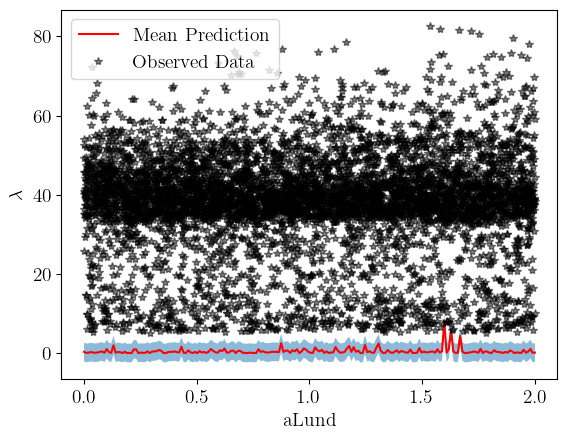

In [191]:
plot_model_param(model, 'aLund')

In [192]:
def print_parameters(model):
    state_dict = model.state_dict()
    for param_name, param_tensor in state_dict.items():
        print(param_name, param_tensor)

In [193]:
print_parameters(model)

likelihood.noise_covar.raw_noise tensor([0.], dtype=torch.float64)
likelihood.noise_covar.raw_noise_constraint.lower_bound tensor(1.0000e-04, dtype=torch.float64)
likelihood.noise_covar.raw_noise_constraint.upper_bound tensor(inf, dtype=torch.float64)
mean_module.raw_constant tensor(0., dtype=torch.float64)
covar_module.raw_outputscale tensor(0., dtype=torch.float64)
covar_module.base_kernel.raw_lengthscale tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       dtype=torch.float64)
covar_module.base_kernel.raw_lengthscale_constraint.lower_bound tensor(0., dtype=torch.float64)
covar_module.base_kernel.raw_lengthscale_constraint.upper_bound tensor(inf, dtype=torch.float64)
covar_module.raw_outputscale_constraint.lower_bound tensor(0., dtype=torch.float64)
covar_module.raw_outputscale_constraint.upper_bound tensor(inf, dtype=torch.float64)


## Tune hyperparameters of GP model (train model)

We tune the hyperparameters by maximizing the marginal log likelihood (MLL) (i.e. treating -MLL as the loss and minimizing it)

$$ \text{MLL} = p_f(\mathbf{y} \mid \mathbf{X})=\int p(\mathbf{y} \mid f(\mathbf{X})) p(f(\mathbf{X}) \mid \mathbf{X}) d f $$

$$ \mathcal{L}= - \text{MLL}$$

In [194]:
def train_model(model, train_x, train_y, n_epochs, print_=False):
    # Use the Adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    
    
    # Optimize the model
    model.train()
    for epoch in range(n_epochs):
        optimizer.zero_grad()
        output = model(train_x)
        loss = - mll(output, train_y)
        if print_:
                print('Epoch %d/%d - Loss: %.3f   lengthscale: %s   noise: %.3f\n' % (
        epoch + 1, n_epochs, loss.item(),
        model.covar_module.base_kernel.lengthscale.tolist()[0],
        model.likelihood.noise.item()
    ))
        loss.backward()
        optimizer.step()

In [195]:
train_model(model, train_x, train_y, 50,print_=True)

Epoch 1/50 - Loss: 573.705   lengthscale: [0.6931471805599453, 0.6931471805599453, 0.6931471805599453, 0.6931471805599453, 0.6931471805599453, 0.6931471805599453, 0.6931471805599453, 0.6931471805599453, 0.6931471805599453, 0.6931471805599453, 0.6931471805599453, 0.6931471805599453, 0.6931471805599453, 0.6931471805599453, 0.6931471805599453]   noise: 0.693

Epoch 2/50 - Loss: 526.559   lengthscale: [0.7443966598724533, 0.7443966598671412, 0.744396659882259, 0.744396659885567, 0.744396659878966, 0.7443966598849965, 0.7443966596157782, 0.7443966596326597, 0.7443966599422344, 0.7443966599469466, 0.744396659945601, 0.744396659947422, 0.7443966599457871, 0.744396650899282, 0.7443966598596445]   noise: 0.744

Epoch 3/50 - Loss: 480.780   lengthscale: [0.7972570684175518, 0.7973694138982067, 0.7973287903467848, 0.7973323331155279, 0.7972965856484016, 0.7973383817299221, 0.7975325560959989, 0.7975830624484652, 0.7970444447224729, 0.7970865288958071, 0.7970583379314876, 0.7970924239543781, 0.797

In [196]:
print_parameters(model)

likelihood.noise_covar.raw_noise tensor([2.0910], dtype=torch.float64)
likelihood.noise_covar.raw_noise_constraint.lower_bound tensor(1.0000e-04, dtype=torch.float64)
likelihood.noise_covar.raw_noise_constraint.upper_bound tensor(inf, dtype=torch.float64)
mean_module.raw_constant tensor(2.0300, dtype=torch.float64)
covar_module.raw_outputscale tensor(2.1882, dtype=torch.float64)
covar_module.base_kernel.raw_lengthscale tensor([[ 2.4710,  2.4440,  2.4353,  2.4577,  2.4224,  2.4556,  1.2778,  1.3084,
          2.6195,  2.6413,  2.6432,  2.6683,  2.6626, -0.7759,  2.4284]],
       dtype=torch.float64)
covar_module.base_kernel.raw_lengthscale_constraint.lower_bound tensor(0., dtype=torch.float64)
covar_module.base_kernel.raw_lengthscale_constraint.upper_bound tensor(inf, dtype=torch.float64)
covar_module.raw_outputscale_constraint.lower_bound tensor(0., dtype=torch.float64)
covar_module.raw_outputscale_constraint.upper_bound tensor(inf, dtype=torch.float64)


/tmp/ipykernel_133/4023912743.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(empty)


(200,)


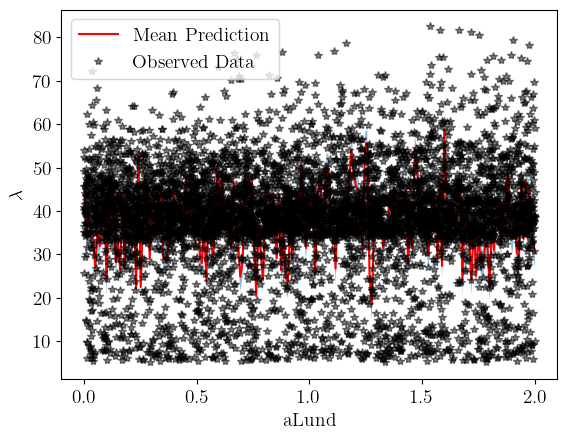

In [197]:
plot_model_param(model, 'aLund')

In [198]:
def get_observed_best_parameters(model):
    train_x = model.train_inputs[0].numpy()
    train_y = model.train_targets.numpy()
    observed_min = train_x[train_y.argmin()]
    param_names = list(PARAM_DICT.keys())
    param_names = [param_name.split(':')[1] for param_name in param_names]
    best_params_dict = {k: v for k, v in zip(param_names, observed_min)}
    return best_params_dict

## Validate the results and observe the data-MC agreement is bad at this point

1. Make the pythia card with the best parameters based on the Bayesian Optimization above
2. Run the pythia card with 300,000 events yielding a test.yoda validation output
3. convert yoda histograms to pandas dataframes, filter histograms and plot result agreement with data

In [125]:
def make_pythia_valid_card(best_parameters):
    
    cards_dir = os.path.join(os.getcwd(), "BO_Cards")
    filename = f"ALEPH_1996_S3486095_BO_card_valid.cmnd"
    file_path = os.path.join(cards_dir, filename)
    with open(file_path,'w') as f:
        first_block="""Main:numberOfEvents = 300000          ! number of events to generate
Next:numberShowEvent = 0           ! suppress full listing of first events
# random seed
Random:setSeed = on
Random:seed= 0
! 2) Beam parameter settings.
Beams:idA = 11                ! first beam,  e- = 11
Beams:idB = -11                ! second beam, e+ = -11
Beams:eCM = 91.2               ! CM energy of collision
# Pythia 8 settings for LEP
# Hadronic decays including b quarks, with ISR photons switched off
WeakSingleBoson:ffbar2gmZ = on
23:onMode = off
23:onIfAny = 1 2 3 4 5
PDF:lepton = off
SpaceShower:QEDshowerByL = off\n\n"""
        f.write(first_block)
        # f.write(f"Random:seed={indx+1}")

        f.write("StringZ:aLund = {}\n\n".format(best_parameters["aLund"]))
        f.write("StringZ:bLund = {}\n\n".format(best_parameters["bLund"]))
        f.write("StringZ:rFactC = {}\n\n".format(best_parameters["rFactC"]))
        f.write("StringZ:rFactB = {}\n\n".format(best_parameters["rFactB"]))
        f.write("StringZ:aExtraSQuark = {}\n\n".format(best_parameters["aExtraSQuark"]))
        f.write("StringZ:aExtraDiquark = {}\n\n".format(best_parameters["aExtraDiquark"]))
        f.write("StringPT:sigma = {}\n\n".format(best_parameters["sigma"]))
        f.write("StringPT:enhancedFraction = {}\n\n".format(best_parameters["enhancedFraction"]))
        f.write("StringPT:enhancedWidth = {}\n\n".format(best_parameters["enhancedWidth"]))
        f.write("StringFlav:ProbStoUD = {}\n\n".format(best_parameters["ProbStoUD"]))
        f.write("StringFlav:probQQtoQ = {}\n\n".format(best_parameters["probQQtoQ"]))
        f.write("StringFlav:probSQtoQQ = {}\n\n".format(best_parameters["probSQtoQQ"]))
        f.write("StringFlav:ProbQQ1toQQ0 = {}\n\n".format(best_parameters["ProbQQ1toQQ0"]))
        f.write("TimeShower:alphaSvalue = {}\n\n".format(best_parameters["alphaSvalue"]))
        f.write("TimeShower:pTmin = {}\n\n".format(best_parameters["pTmin"]))
def run_valid_card(best_parameters):
    
    # step 1: write .cmnd file 
    make_pythia_valid_card(best_parameters)
    #step 2 run main42 and rivet
    os.system("""./main42 BO_Cards/ALEPH_1996_S3486095_BO_card_valid.cmnd /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card_valid.fifo
    rivet -o ALEPH_1996_S3486095_hist_valid_0.yoda -a ALEPH_1996_S3486095 /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card_valid.fifo

    rm /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card_valid.fifo
    mv ALEPH_1996_S3486095_hist_valid_0.yoda ALEPH_YODAS_BayesOpt/""")

----

# Bayesian Optimization

Bayesian optimization is the optimization of a complex black box function (such as an objective function) $f(x)$ through iterative pointwise queries. The objective function is expensive, so it cannot be exhaustively evaluated. The function is also noisy, so repeated queries may yield different results.

We wish to find an optimal set of parameters $\mathbf{x}^*$ of the objective function

$$ \mathbf{x}^* = \text{arg max}_{\mathbf{x}\in \mathcal{R}^D} f(\mathbf{x})$$

In a nutshell, the algorithm works by forming a surrogate model $\hat{f}(x)$ by a GP of the objective function $f(x)$. 
$$ \hat{f}(\mathbf{x}) \sim \text{GP} (m(\mathbf{x}), k(\mathbf{x}))$$

We choose the next point through an acquisition function. We then evaluate and update the model, and repeat.

1. Construct a GP surrogate (regression) model $\hat{f}(x)$ of a function $f(x)$ using the sample $D = \{(x_i, f(x_i))\}_{i = 1}^n$
2. Select a new point that maximize an acquisition function $\alpha(x)$
$$
x_{new} = \arg\max\limits_x \alpha(x)
$$
3. Calculate $f(x_{new})$ at the new point.
4. Add the pair $(x_{new}, f(x_{new}))$ to the sample $D$.
5. Update the model $\hat{f}(x)$ and go to step 2.

## Expected Improvement

$$\operatorname{EI}(x)=\mathbb{E}\left[\max \left(f_{\text {best }}-f(x), 0\right)\right]$$

Assuming $f(x) \sim \mathcal{N}\left(\mu(x), \sigma(x)^2\right)$, the EI can be written as

$$\mathrm{EI}(x)=\left(\mu(x)-f_{\text {best }}-\xi\right) \Phi(Z)+\sigma(x) \phi(Z)$$

where

- $$\begin{array}{l}
Z=\frac{\mu(x)-f_{\text {bost }}-\xi}{\sigma(x)} \text { if } \sigma(x)>0 \\
Z=0 \text { if } \sigma(x)=0
\end{array}$$

- $\Phi$ is the CDF of the standard normal distribution, $\phi(x)$ is the PDF of the standard normal  distribution

- $\xi$ is a small non-negative number (often set to zero) to introduce a trade-off between exploitation and exploration. **the larger the $\xi$ the more exploration** 

In [126]:
def expected_improvement(model, observed_y, candidate_set):
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        observed_pred = model.predict(candidate_set)
        best_f = observed_y.min()
        
        mean = observed_pred.mean
        sigma = observed_pred.variance.sqrt()
        gamma = (best_f - mean) / sigma
        ei = sigma * (gamma * torch.distributions.Normal(0, 1).cdf(gamma) + torch.distributions.Normal(0, 1).log_prob(gamma).exp())
        return ei


In [127]:
x_candidates = make_x_candidates(PARAM_DICT,2)
print(x_candidates)
next_x = x_candidates[0]
a = torch.cat([train_x, next_x.unsqueeze(0)])
print(a)

tensor([[1.9599, 0.9641, 1.1907, 0.8987, 1.8026, 0.8576, 0.7678, 0.9810, 1.0603,
         1.5004, 2.8215, 1.4294, 2.8091, 0.2395, 1.6363],
        [0.2089, 1.1653, 0.8547, 0.4373, 0.5869, 0.3003, 0.3693, 0.1239, 2.3890,
         1.7921, 1.0450, 1.9358, 1.1421, 0.1571, 0.1700]], dtype=torch.float64)
tensor([[1.0188e+00, 1.9076e+00, 5.9363e-01, 1.2860e+00, 4.6975e-01, 6.1668e-01,
         3.2163e-01, 9.3016e-02, 3.3540e+00, 2.5027e+00, 1.6118e+00, 3.7281e+00,
         3.5305e+00, 1.5010e-01, 1.0867e+00],
        [9.8872e-01, 4.7102e-01, 1.7641e+00, 4.6279e-01, 1.9213e+00, 8.7217e-01,
         8.5532e-01, 9.6950e-01, 1.3994e+00, 3.8186e+00, 1.1488e+00, 2.5890e+00,
         2.0946e+00, 1.1420e-01, 1.9305e+00],
        [4.4419e-01, 1.8344e+00, 1.2392e-01, 1.9641e+00, 7.3380e-01, 1.4304e+00,
         2.2308e-01, 8.1272e-01, 2.7540e+00, 3.0163e+00, 7.4418e-02, 4.3306e-02,
         2.4766e+00, 1.0042e-01, 1.3586e+00],
        [4.6367e-01, 1.6476e+00, 1.4844e+00, 7.0637e-01, 1.9155e+00, 1.5798e

In [ ]:
def BayesOpt_all_params(model, 
                        train_x, 
                        train_y, 
                        n_iterations, 
                        retrain_gp=False,
                        print_=False,
                       save_model=False):
    # Use the Adam optimizer

    model.eval()
    likelihood.eval()
    
    Monash_candidate = torch.tensor(list(MONASH_DICT.values()))
    next_y = true_objective_func(*Monash_candidate)
    train_x = torch.cat([train_x, Monash_candidate.unsqueeze(0)])
    next_y = torch.tensor([next_y])
    train_y = torch.cat([train_y, next_y])
    model.set_train_data(inputs=train_x, targets=train_y, strict=False)
    train_model(model, train_x, train_y, 25, print_=print_)
    
    for iteration in range(n_iterations):

        x_candidates = make_x_candidates(PARAM_DICT,1000)
        ei = expected_improvement(model, train_y, x_candidates)
        ei_argmax = ei.argmax()
        next_x = x_candidates[ei_argmax]
        next_y = true_objective_func(*next_x)
        train_x = torch.cat([train_x, next_x.unsqueeze(0)])
        next_y = torch.tensor([next_y])

        print(f'epoch {iteration} next_x = {next_x}, next_y = {next_y}')
        train_y = torch.cat([train_y, next_y])

        model.set_train_data(inputs=train_x, targets=train_y, strict=False)
        
        # retrain model with updated data
        if retrain_gp:
            model.train()
            train_model(model, train_x, train_y, 25, print_=print_)

    train_size=train_x.shape[0]
    if save_model:
        path = f'models/GPytorch_all_params_model_Niter_{n_iterations}_trainsize_{train_size}.pth'
        torch.save(model.state_dict(), path)
        
        

In [ ]:
BayesOpt_all_params(model, 
                    train_x, 
                    train_y, 
                    20, 
                    retrain_gp=True,
                    print_=False,
                   save_model=False)


 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file /media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |  

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-27 21:41:46
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:01 elapsed)
Event 400 (0:00:01 elapsed)
Event 500 (0:00:01 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:02 elapsed)
Event 1200 (0:00:02 elapsed)
Event 1300 (0:00:02 elapsed)
Event 1400 (0:00:02 elapsed)
Event 1500 (0:00:02 elapsed)
Event 1600 (0:00:02 elapsed)
Event 1700 (0:00:02 elapsed)
Event 1800 (0:00:03 elapsed)
Event 1900 (0:00:03 elapsed)
Event 2000 (0:00:03 elapsed)
Event 2100 (0:00:03 elapsed)
Event 2200 (0:00:03 elapsed)
Event 2300 (0:00:03 elapsed)
Event 2400 (0:00:03 elapsed)
Event 2500 (0:00:03 elapsed)
Finished event loop at 2024-06-27 21:41:49
Cross-section = 4.144341e+04 pb
Rivet run completed at 2024-06-27 21:41:49, time elapsed = 0





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 13.00it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda


DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw   sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  12.080000  0.9664  0.043312  0.033817       151.0
1  0.005  0.010  24.959999  1.9968  0.187465  0.292530       312.0
2  0.010  0.015  22.480000  1.7984  0.279620  0.705156       281.0
3  0.015  0.020  16.799999  1.3440  0.292170  1.023825       210.0
4  0.020  0.025  12.400000  0.9920  0.277180  1.244592       155.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d05-x01-y01', '/REF

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-27 21:41:57
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Finished event loop at 2024-06-27 21:41:57
Cross-section = 2.709761e+04 pb
Rivet run completed at 2024-06-27 21:41:57, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 13.35it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda


DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw       sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  11.764706  138.408325  0.049845  0.042237         1.0
1  0.005  0.010  11.764706  138.408325  0.080494  0.110147         1.0
2  0.010  0.015   0.000000    0.000000  0.000000  0.000000         0.0
3  0.015  0.020   0.000000    0.000000  0.000000  0.000000         0.0
4  0.020  0.025  23.529421  276.816589  0.518697  2.287150         2.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S348

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-27 21:42:46
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Finished event loop at 2024-06-27 21:42:46
Cross-section = 3.909201e+04 pb
Rivet run completed at 2024-06-27 21:42:46, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 13.04it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda


DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh      sumw     sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  3.007518  4.522584  0.007727  0.004470         2.0
1  0.005  0.010  6.015038  9.045168  0.048855  0.080935         4.0
2  0.010  0.015  1.503759  2.261292  0.020300  0.054805         1.0
3  0.015  0.020  4.511278  6.783876  0.079171  0.280299         3.0
4  0.020  0.025  4.511278  6.783876  0.098902  0.435342         3.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d05-x01-y01',

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-27 21:43:35
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Finished event loop at 2024-06-27 21:43:35
Cross-section = 3.961502e+04 pb
Rivet run completed at 2024-06-27 21:43:35, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



  0%|                                                     | 0/2 [00:00<?, ?it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  5.87it/s]


using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh      sumw     sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  2.051282  2.103879  0.005240  0.003021         2.0
1  0.005  0.010  6.153846  6.311636  0.046389  0.071995         6.0
2  0.010  0.015  1.025641  1.051940  0.010794  0.022721         1.0
3  0.015  0.020  3.076924  3.155818  0.057777  0.217484         3.0
4  0.020  0.025  5.128206  5.259696  0.113841  0.507892         5.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S348609

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-27 21:44:22
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Finished event loop at 2024-06-27 21:44:22
Cross-section = 3.928739e+04 pb
Rivet run completed at 2024-06-27 21:44:22, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 12.11it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda


DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh      sumw     sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  1.219512  1.487210  0.004482  0.003295         1.0
1  0.005  0.010  4.878048  5.948840  0.040848  0.070124         4.0
2  0.010  0.015  4.878048  5.948840  0.061807  0.159877         4.0
3  0.015  0.020  1.219512  1.487210  0.023255  0.088690         1.0
4  0.020  0.025  3.658536  4.461628  0.079774  0.349059         3.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d05-x01-y01',

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-27 21:45:10
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Finished event loop at 2024-06-27 21:45:10
Cross-section = 3.763738e+04 pb
Rivet run completed at 2024-06-27 21:45:10, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 12.05it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda


DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh      sumw      sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  2.247192   5.049868  0.006313  0.003547         1.0
1  0.005  0.010  0.000000   0.000000  0.000000  0.000000         0.0
2  0.010  0.015  2.247192   5.049868  0.027870  0.069130         1.0
3  0.015  0.020  2.247192   5.049868  0.043794  0.170698         1.0
4  0.020  0.025  8.988764  20.199469  0.209419  0.976739         4.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d05-x01

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-27 21:45:58
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:01 elapsed)
Event 200 (0:00:01 elapsed)
Finished event loop at 2024-06-27 21:45:59
Cross-section = 3.990847e+04 pb
Rivet run completed at 2024-06-27 21:45:59, time elapsed = 0:00:01
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



  0%|                                                     | 0/2 [00:00<?, ?it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 10.45it/s]



using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw      sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  15.384616  13.149244  0.039576  0.026822        18.0
1  0.005  0.010  13.675214  11.688216  0.106354  0.171556        16.0
2  0.010  0.015  10.256410   8.766164  0.127994  0.323235        12.0
3  0.015  0.020  12.820512  10.957704  0.215925  0.733249        15.0
4  0.020  0.025  13.675214  11.688216  0.313479  1.441958        16.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', 

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-27 21:46:47
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Finished event loop at 2024-06-27 21:46:47
Cross-section = 3.811313e+04 pb
Rivet run completed at 2024-06-27 21:46:47, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  9.44it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  8.42it/s]



using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw      sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   9.708738  18.851919  0.018121  0.011602         5.0
1  0.005  0.010   3.883496   7.540768  0.031829  0.052915         2.0
2  0.010  0.015   1.941748   3.770384  0.025189  0.065350         1.0
3  0.015  0.020  13.592234  26.392685  0.229008  0.778946         7.0
4  0.020  0.025   7.766990  15.081536  0.173828  0.781560         4.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', 

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-27 21:47:35
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Finished event loop at 2024-06-27 21:47:36
Cross-section = 3.872085e+04 pb
Rivet run completed at 2024-06-27 21:47:36, time elapsed = 0:00:01
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 12.18it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda


DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh     sumw      sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   9.3750  14.648436  0.023693  0.013837         6.0
1  0.005  0.010  10.9375  17.089844  0.081842  0.130598         7.0
2  0.010  0.015   7.8125  12.207032  0.090493  0.211940         5.0
3  0.015  0.020   4.6875   7.324220  0.085039  0.309799         3.0
4  0.020  0.025  12.5000  19.531248  0.281021  1.269558         8.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d05-x01-y01',

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-27 21:48:25
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Finished event loop at 2024-06-27 21:48:25
Cross-section = 3.887106e+04 pb
Rivet run completed at 2024-06-27 21:48:25, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 12.77it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda


DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh      sumw     sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  4.411764  6.487888  0.011092  0.007764         3.0
1  0.005  0.010  1.470588  2.162630  0.009554  0.012413         1.0
2  0.010  0.015  5.882352  8.650520  0.071486  0.175401         4.0
3  0.015  0.020  1.470588  2.162630  0.022446  0.068521         1.0
4  0.020  0.025  4.411764  6.487888  0.103662  0.487594         3.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d05-x01-y01',

Rivet 3.1.9 running on machine 317facd36457 (x86_64) at 2024-06-27 21:49:14
Reading events from '/media/ali/DATA/TEMP/ALEPH_1996_S3486095_card.fifo'
Finished event loop at 2024-06-27 21:49:14
Cross-section = 3.789112e+04 pb
Rivet run completed at 2024-06-27 21:49:14, time elapsed = 0:00:00
Histograms written to /home/ali/Desktop/Pulled_Github_Repositories/Pythia8_SBI_Tune/code/BayesOpt/ALEPH_1996_S3486095_hist_0.yoda






Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



 50%|██████████████████████▌                      | 1/2 [00:00<00:00,  9.32it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda


100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 10.23it/s]



using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh      sumw     sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  2.083334  4.340276  0.000187  0.000003         1.0
1  0.005  0.010  2.083334  4.340276  0.013737  0.018116         1.0
2  0.010  0.015  2.083334  4.340276  0.022150  0.047098         1.0
3  0.015  0.020  2.083334  4.340276  0.033717  0.109136         1.0
4  0.020  0.025  4.166666  8.680556  0.089053  0.380692         2.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_

/tmp/ipykernel_133/4023912743.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(empty)


(200,)


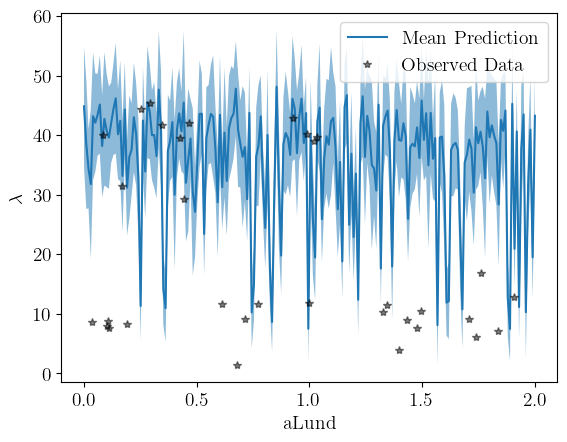

In [171]:
plot_model_param(model, 'aLund')

In [172]:
best_observed_params =get_observed_best_parameters(model)
best_observed_params

{'aLund': 0.6800000071525574,
 'bLund': 0.9800000190734863,
 'rFactC': 1.3200000524520874,
 'rFactB': 0.8550000190734863,
 'aExtraSQuark': 0.0,
 'aExtraDiquark': 0.9700000286102295,
 'sigma': 0.33500000834465027,
 'enhancedFraction': 0.009999999776482582,
 'enhancedWidth': 2.0,
 'ProbStoUD': 0.21699999272823334,
 'probQQtoQ': 0.08100000023841858,
 'probSQtoQQ': 0.9150000214576721,
 'ProbQQ1toQQ0': 0.027499999850988388,
 'alphaSvalue': 0.13650000095367432,
 'pTmin': 0.5}